## This code is to check if hdea direction cells in ADN and PoS recorded by Duszkiewicz et al, show firing rate adaptation.

In [1]:
import os
import numpy as np
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

import utils

%load_ext autoreload
%autoreload 2

In [2]:
def plot_head_direction_tuning(ax, angle_data, angle4spike, config, pos_tb=0.01):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """


    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(angle_data, bins=config['hd_bins'], range=(-np.pi, np.pi))
    hd2, _ = np.histogram(angle4spike, bins=config['hd_bins'], range=(-np.pi, np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time
    # #where hd3 is nan, set it to 0
    # hd3 = np.nan_to_num(hd3)
    
    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.nanmax(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(-np.pi, np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    
    #remove yticks
    ax.set_yticks([])
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    prefer_hd = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([prefer_hd, prefer_hd], [0, 1], color='red', linestyle='--', linewidth=1)
    
    return ax, prefer_hd

def get_adaptation(angle_data, t, spiket, prefer_hd, degreerange=6, timelength=0.33, timecut=0.16, rotType='still'):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        t (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        prefer_hd (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    # Convert angle_data from radians to degrees and wrap it to 0-360
    angle_data = np.rad2deg(angle_data)
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(prefer_hd)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (angle_data - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    
    inst_fr = []
    durations = []
    
    count = 0
    for start, end in zip(start_indices, end_indices):
        start_time = t[start]
        end_time = t[end]
        
        #if end_time - start_time < 0.3: do not consider this period
        # if end_time - start_time < timelength or end_time - start_time > 2:
        if rotType == 'still':
            if end_time - start_time < timelength:
                continue
        elif rotType == 'rot':
            if end_time - start_time < timelength or end_time - start_time > 2:
                continue
            timecut = (end_time - start_time) / 2
        # #consider only those head rotating periods when entering from one side and leaving from the other side
        anglewithinrange = angle_data[start:end]-preferred_direction
        # #the sign of the anglewithinrange should be different at the start and end
        if anglewithinrange[0] * anglewithinrange[-1] > 0:
            continue
        
        count += 1 
        
        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = spiket[(spiket >= start_time) & (spiket <= start_time+timecut)]
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = spiket[(spiket > end_time - timecut) & (spiket <= end_time)]
        
        # Ensure at least two spikes exist in each window
        if len(spikes_in_period_firsthalf) < 1 or len(spikes_in_period_secondhalf) < 1:
            continue
        
        # Ensure ISI calculation doesn't include zero values
        # don't know why, but happen few times....
        if 0 in np.diff(spikes_in_period_firsthalf) or 0 in np.diff(spikes_in_period_secondhalf):
            continue

        # #calculate the instantaneous firing rate
        # initial_instfr = np.mean(1./np.diff(spikes_in_period_firsthalf))
        # final_instfr = np.mean(1./np.diff(spikes_in_period_secondhalf))
        
        #calculate the mean firing rate
        initial_instfr = len(spikes_in_period_firsthalf) / timecut
        final_instfr = len(spikes_in_period_secondhalf) / timecut
        
        inst_fr.append((initial_instfr, final_instfr))
        durations.append(end_time - start_time)
    
    return inst_fr, durations

def extract_initial_final_instfr(instfr, takewithincellmean=False):
    initial_instfr = []
    final_instfr = []
    if takewithincellmean is False:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                for j in range(len(instfr[i])):
                    initial_instfr.append(instfr[i][j][0])
                    final_instfr.append(instfr[i][j][1])
    else:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                initial_instfr.append(np.mean([instfr[i][j][0] for j in range(len(instfr[i]))]))
                final_instfr.append(np.mean([instfr[i][j][1] for j in range(len(instfr[i]))]))
    return initial_instfr, final_instfr

def extract_dur(dur):
    #dur is a list of list
    #change to a list
    durations = []
    for i in range(len(dur)):
        if len(dur[i]) == 0:
            continue
        else:
            for j in range(len(dur[i])):
                durations.append(dur[i][j])
    return durations

def get_adaptation_for_all(datafolder, area, degreerange, timelength, timecut, return_mean=False, rotType='still'):
    '''
    Input: brainarea: adn or pos
    '''
    
    allcell_instfr = []
    allcell_dur = []

    # all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
    animalfolders = os.listdir(datafolder)

    for folder in animalfolders:
        mousetrial = datafolder + folder + '/Data'
        
        print('Processing ' + folder)
        
        #load data
        data = utils.load_data(mousetrial)
        t = data['t']
        
        # #check if t has regular intervals if not, print
        # if np.all(np.diff(t) == np.diff(t)[0]) is False:
        #     print('Time intervals are not regular')
        
        angle_data = data['angle_data']
        brainarea = data[area] 
        hd = data['hd']
        # idx = np.where(brainarea == 1)[0]
        spike_times = data['spike_times']
        # spike_times = [spike_times[i] for i in idx]
        
        # Configuration
        config = {
            'hd_bins': 60,
            'hd_boxcar': 3,
        }
        
        #plot all directional tuning
        fig = plt.figure(figsize=(2*len(spike_times),2))
        for i in range(len(spike_times)):
            spike_time_cell_i = spike_times[i]
            spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

            #calculate the head direction angle when spike_array_cell_i is not zero
            angle4spike = angle_data[spike_array_cell_i != 0]

            ax = fig.add_subplot(1,len(spike_times),i+1, polar=True)
            ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

            #calculate firing rate adaptation
            inst_fr, dur = get_adaptation(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength, timecut=timecut, rotType=rotType)

            #if cell is a hd and adn cell then save the inst_fr and dur
            if hd[i] == 1 and brainarea[i] == 1:
                allcell_instfr.append(inst_fr)
                allcell_dur.append(dur)

        plt.close()
        
    #extract initial and final instfr
    initial_instfr, final_instfr = extract_initial_final_instfr(allcell_instfr, takewithincellmean=True)
    durations = extract_dur(allcell_dur)
    
    if return_mean:
        return np.mean(initial_instfr), np.mean(final_instfr), np.mean(durations)
    else:
        return initial_instfr, final_instfr, durations

### check one cell example

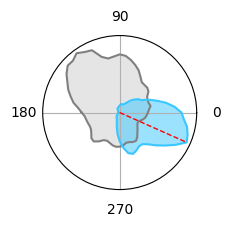

In [3]:
mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/A1104-180328/Data'

#load data
data = utils.load_data(mousetrial)

t = data['t']
angle_data = data['angle_data']

adn = data['adn']
hd = data['hd']

idx = np.where((adn == 1) & (hd==1))[0]

spike_times = data['spike_times']

spike_times = [spike_times[i] for i in idx]

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
}
degreerange = 15 #Taube & Muller 1998
timecut = 0.15 #Taube & Muller 1998
timelength = 2*timecut

#angle4spike
spike_time_cell_i = spike_times[0]
spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

#calculate the head direction angle when spike_array_cell_i is not zero
angle4spike = angle_data[spike_array_cell_i != 0]

fig = plt.figure(figsize=(2,2))

ax = fig.add_subplot(111, polar=True)
ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

#caulcate firing rate adaptation 
inst_fr, dur = get_adaptation(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength, timecut=timecut, rotType='still')



### check all HD cells in ADN (Dataset_5)

In [4]:
rotType = 'still'
if rotType == 'still':
    degreerange = 15 
    timecut = 0.15 
    timelength = 1.5
elif rotType == 'rot':
    degreerange = 15 
    timecut = None
    timelength = 0.01  
else:
    raise ValueError('rotType should be still or rot')
    
datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/'
area = 'adn'
initial_instfr_adn, final_instfr_adn, durations_adn = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False,
                                                                 rotType=rotType)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr_adn), 
                                                                         np.std(initial_instfr_adn)/np.sqrt(len(initial_instfr_adn)),
                                                                         np.mean(final_instfr_adn), 
                                                                         np.std(final_instfr_adn)/np.sqrt(len(final_instfr_adn))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr_adn), np.array(final_instfr_adn))
print('Statistics=%.3f, p=%.3f' % (stat, p))

print('number of head direction cell in adn: ', len(initial_instfr_adn))

print('mean duration: {:.2f} +- {:.2f}'.format(np.mean(durations_adn), np.std(durations_adn)/np.sqrt(len(durations_adn))))

Processing A1106-180419
Processing A1110-180626
Processing A1113-180813
Processing A1106-180418
Processing A1110-180619
Processing A1113-180814
Processing A1110-180617
Processing A1112-180711
Processing A1110-180621
Processing A1104-180329
Processing A1110-180613
Processing A1112-180709
Processing A1104-180328
Processing B0703-211208
Processing B0201-210922
Processing A1113-180816
Processing A1109-180619
Processing A1110-180612
Processing A1109-180615
Initial firing rate: 42.71 +- 3.37 Final firing rate: 34.41 +- 2.76
Statistics=398.000, p=0.000
number of head direction cell in adn:  81
mean duration: 2.86 +- 0.09


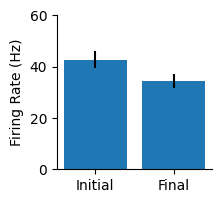

In [5]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr_adn), np.mean(final_instfr_adn)], 
        yerr=[np.std(initial_instfr_adn)/np.sqrt(len(initial_instfr_adn)), np.std(final_instfr_adn)/np.sqrt(len(final_instfr_adn))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 60])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### check all HD cells in PoS (Dataset_2)

In [6]:
rotType = 'still'
if rotType == 'still':
    degreerange = 15 
    timecut = 0.15 
    timelength = 1.5
elif rotType == 'rot':
    degreerange = 15 
    timecut = None
    timelength = 0.01  
else:
    raise ValueError('rotType should be still or rot')

datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_2/'
area = 'pos'

initial_instfr_pos2, final_instfr_pos2, durations_pos2 = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False,
                                                                 rotType = rotType)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr_pos2), 
                                                                         np.std(initial_instfr_pos2)/np.sqrt(len(initial_instfr_pos2)),
                                                                         np.mean(final_instfr_pos2), 
                                                                         np.std(final_instfr_pos2)/np.sqrt(len(final_instfr_pos2))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr_pos2), np.array(final_instfr_pos2))
print('Statistics=%.3f, p=%.3f' % (stat, p))


print('number of head direction cell in pos: ', len(initial_instfr_pos2))

print('mean duration: {:.2f} +- {:.2f}'.format(np.mean(durations_pos2), np.std(durations_pos2)/np.sqrt(len(durations_pos2))))

Processing A5507-200920
Processing A9701-210805
Processing A5508-200930
Processing A6215-210610
Processing A1824-190827
Processing A1813-190408
Processing A5506-200914a
Processing A6216-210623
Processing A1808-190807
Processing A6211-210407
Processing A1821-190910
Processing A5505-200831
Processing A1815-190523
Processing A5801-200924
Initial firing rate: 23.18 +- 0.62 Final firing rate: 19.03 +- 0.44
Statistics=19549.000, p=0.000
number of head direction cell in pos:  416
mean duration: 3.39 +- 0.07


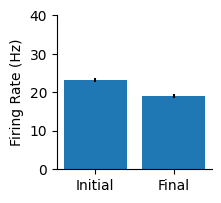

In [7]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr_pos2), np.mean(final_instfr_pos2)], 
        yerr=[np.std(initial_instfr_pos2)/np.sqrt(len(initial_instfr_pos2)), np.std(final_instfr_pos2)/np.sqrt(len(final_instfr_pos2))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 40])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [8]:
#subsample 97 cells from the pos dataset and redo the stats
np.random.seed(0)

for i in range(100):
    idx = np.random.choice(np.arange(len(initial_instfr_pos2)), len(initial_instfr_adn), replace=False)

    initial_instfr_subsample = [initial_instfr_pos2[i] for i in idx]
    final_instfr_subsample = [final_instfr_pos2[i] for i in idx]

    ##perform a wilcoxon signed rank test
    stat, p = wilcoxon(np.array(initial_instfr_subsample), np.array(final_instfr_subsample))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=519.500, p=0.000
Statistics=678.000, p=0.000
Statistics=946.500, p=0.007
Statistics=659.500, p=0.000
Statistics=750.500, p=0.000
Statistics=686.000, p=0.001
Statistics=440.000, p=0.000
Statistics=917.500, p=0.039
Statistics=622.000, p=0.000
Statistics=708.000, p=0.000
Statistics=1148.500, p=0.073
Statistics=469.000, p=0.000
Statistics=850.000, p=0.006
Statistics=834.000, p=0.005
Statistics=433.000, p=0.000
Statistics=922.500, p=0.002
Statistics=1245.500, p=0.343
Statistics=899.500, p=0.009
Statistics=754.500, p=0.002
Statistics=836.000, p=0.001
Statistics=910.000, p=0.015
Statistics=503.000, p=0.000
Statistics=901.000, p=0.009
Statistics=424.000, p=0.000
Statistics=649.000, p=0.000
Statistics=1144.500, p=0.190
Statistics=514.500, p=0.000
Statistics=456.500, p=0.000
Statistics=911.000, p=0.016
Statistics=679.500, p=0.000
Statistics=782.500, p=0.001
Statistics=739.500, p=0.000
Statistics=1212.000, p=0.142
Statistics=879.000, p=0.002
Statistics=831.500, p=0.011
Statistics=620.5

### check all HD cells in PoS (Dataset_1)

In [9]:
rotType = 'still'
if rotType == 'still':
    degreerange = 15 
    timecut = 0.15 
    timelength = 1.5
elif rotType == 'rot':
    degreerange = 15
    timecut = None
    timelength = 0.01  
else:
    raise ValueError('rotType should be still or rot')

datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/'
area = 'pos'

initial_instfr_pos1, final_instfr_pos1, durations_pos1 = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False,
                                                                 rotType=rotType)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr_pos1), 
                                                                         np.std(initial_instfr_pos1)/np.sqrt(len(initial_instfr_pos1)),
                                                                         np.mean(final_instfr_pos1), 
                                                                         np.std(final_instfr_pos1)/np.sqrt(len(final_instfr_pos1))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr_pos1), np.array(final_instfr_pos1))
print('Statistics=%.3f, p=%.3f' % (stat, p))

print('number of head direction cell in pos: ', len(initial_instfr_pos1))

print('mean duration: {:.2f} +- {:.2f}'.format(np.mean(durations_pos1), np.std(durations_pos1)/np.sqrt(len(durations_pos1))))



Processing A3709-200601
Processing A3713-200909a
Processing A3703-191215
Processing A3728-210309b
Processing A3730-210323b
Processing A3705-200306
Processing A3708-200317b
Processing A3706-200313
Processing A3723-201115
Processing A3717-201021
Processing A3712-200903a
Processing A3711-200810b
Processing A3710-200609
Processing A3701-191119
Processing A3707-200317
Processing A3702-191126
Processing A3716-201015b
Initial firing rate: 23.73 +- 0.39 Final firing rate: 20.55 +- 0.31
Statistics=120410.500, p=0.000
number of head direction cell in pos:  932
mean duration: 3.73 +- 0.86


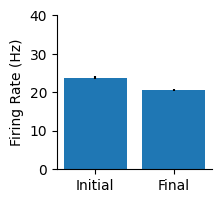

In [10]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr_pos1), np.mean(final_instfr_pos1)], 
        yerr=[np.std(initial_instfr_pos1)/np.sqrt(len(initial_instfr_pos1)), np.std(final_instfr_pos1)/np.sqrt(len(final_instfr_pos1))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 40])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [11]:
#subsample 97 cells from the pos dataset and redo the stats
np.random.seed(0)

for i in range(100):
    idx = np.random.choice(np.arange(len(initial_instfr_pos1)), len(initial_instfr_adn), replace=False)

    initial_instfr_subsample = [initial_instfr_pos1[i] for i in idx]
    final_instfr_subsample = [final_instfr_pos1[i] for i in idx]

    ##perform a wilcoxon signed rank test
    stat, p = wilcoxon(np.array(initial_instfr_subsample), np.array(final_instfr_subsample))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=713.000, p=0.000
Statistics=696.000, p=0.000
Statistics=840.500, p=0.001
Statistics=1442.500, p=0.764
Statistics=1047.000, p=0.067
Statistics=1069.500, p=0.042
Statistics=986.000, p=0.031
Statistics=540.000, p=0.000
Statistics=815.000, p=0.003
Statistics=1115.500, p=0.265
Statistics=1027.000, p=0.024
Statistics=1130.500, p=0.398
Statistics=908.500, p=0.023
Statistics=1062.500, p=0.113
Statistics=1215.000, p=0.199
Statistics=836.000, p=0.003
Statistics=1043.000, p=0.243
Statistics=901.000, p=0.006
Statistics=989.500, p=0.098
Statistics=747.500, p=0.001
Statistics=1260.500, p=0.221
Statistics=659.000, p=0.007
Statistics=887.500, p=0.025
Statistics=1164.500, p=0.306
Statistics=843.000, p=0.013
Statistics=986.000, p=0.006
Statistics=825.000, p=0.002
Statistics=989.500, p=0.069
Statistics=764.500, p=0.000
Statistics=882.500, p=0.003
Statistics=991.500, p=0.070
Statistics=870.000, p=0.008
Statistics=728.500, p=0.001
Statistics=1054.000, p=0.103
Statistics=978.000, p=0.122
Statisti

### put all data together

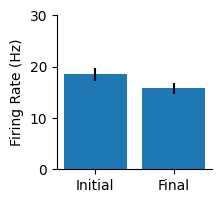

In [26]:
#read processed avn npz data (Lomi et al)
#NB: this is rat data, not mouse data
#save at '/home/zilong/Desktop/HDPhasePrecession/figures/avn_initfinal_fr.npz', initial_instfr_avn=initial_instfr_avn, final_instfr_avn=final_instfr_avn)

initial_instfr_avn = np.load('/home/zilong/Desktop/HDPhasePrecession/figures/avn_initfinal_fr.npz')['initial_instfr_avn']
final_instfr_avn = np.load('/home/zilong/Desktop/HDPhasePrecession/figures/avn_initfinal_fr.npz')['final_instfr_avn']

#plot
fig, ax = plt.subplots(figsize=(2,2))

ax.bar(['Initial', 'Final'],
        [np.mean(initial_instfr_avn), np.mean(final_instfr_avn)], 
        yerr=[np.std(initial_instfr_avn)/np.sqrt(len(initial_instfr_avn)), np.std(final_instfr_avn)/np.sqrt(len(final_instfr_avn))])
ax.set_ylabel('Firing Rate (Hz)')
ax.set_ylim([0, 30])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


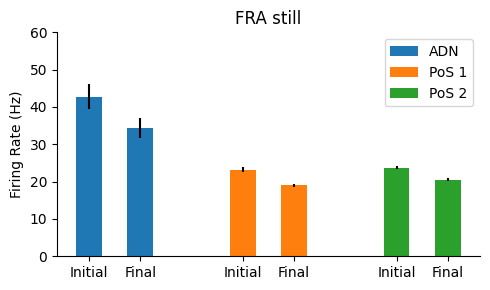

In [27]:
#plot the initial and final firing rate for the three datasets in one plot
#initial_instfr_adn, final_instfr_adn in the first two bars
#initial_instfr_pos2, final_instfr_pos2 in the second two bars
#initial_instfr_pos1, final_instfr_pos1 in the third two bars

fig, ax = plt.subplots(figsize=(5,3))

barWidth = 0.5

r1 = [0,1]
r2 = [3,4]
r3 = [6,7]

ax.bar(r1, [np.mean(initial_instfr_adn), np.mean(final_instfr_adn)],
         yerr=[np.std(initial_instfr_adn)/np.sqrt(len(initial_instfr_adn)), np.std(final_instfr_adn)/np.sqrt(len(final_instfr_adn))],
         width=barWidth, label='ADN')

ax.bar(r2, [np.mean(initial_instfr_pos2), np.mean(final_instfr_pos2)],
            yerr=[np.std(initial_instfr_pos2)/np.sqrt(len(initial_instfr_pos2)), np.std(final_instfr_pos2)/np.sqrt(len(final_instfr_pos2))],
            width=barWidth, label='PoS 1')

ax.bar(r3, [np.mean(initial_instfr_pos1), np.mean(final_instfr_pos1)],
            yerr=[np.std(initial_instfr_pos1)/np.sqrt(len(initial_instfr_pos1)), np.std(final_instfr_pos1)/np.sqrt(len(final_instfr_pos1))],
            width=barWidth, label='PoS 2')

ax.set_ylabel('Firing Rate (Hz)')
ax.set_xticks([0, 1, 3, 4, 6, 7])
ax.set_xticklabels(['Initial', 'Final', 'Initial', 'Final', 'Initial', 'Final'])
ax.legend()

#ylim = 70-90

ax.set_ylim([0, 60])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('FRA ' + rotType)

plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/firingrate_adaptation_' + rotType + '.png', dpi=300)

    

ADN vs PoS 1: p = 0.002543408578064758
ADN vs PoS 2: p = 0.00018903130158483397
PoS 1 vs PoS 2: p = 0.1481739565907267


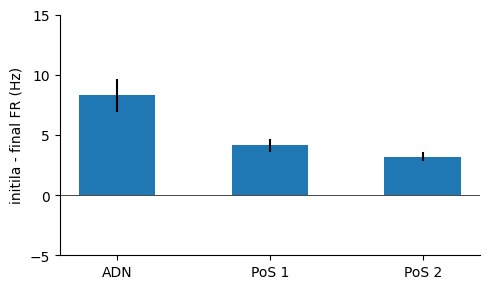

In [22]:
#calculate the difference in firing rate adaptation between initial and final firing rate in three datasets

diff_adn = np.array(initial_instfr_adn) - np.array(final_instfr_adn)
diff_pos2 = np.array(initial_instfr_pos2) - np.array(final_instfr_pos2)
diff_pos1 = np.array(initial_instfr_pos1) - np.array(final_instfr_pos1)

#plot the difference in firing rate adaptation in three datasets
fig, ax = plt.subplots(figsize=(5,3))

barWidth = 0.5

x = [0, 1, 2]

ax.bar(x, [np.mean(diff_adn), np.mean(diff_pos2), np.mean(diff_pos1)],
            yerr=[np.std(diff_adn)/np.sqrt(len(diff_adn)), np.std(diff_pos2)/np.sqrt(len(diff_pos2)), np.std(diff_pos1)/np.sqrt(len(diff_pos1))],
            width=barWidth)

ax.set_ylabel('initila - final FR (Hz)')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['ADN', 'PoS 1', 'PoS 2'])

ax.set_ylim([-5, 15])
ax.set_yticks([-5, 0, 5, 10, 15])

#y=0
ax.axhline(0, color='black', linewidth=0.5)

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

#add significant stars
#t-test between the difference in firing rate adaptation in adn and pos
from scipy.stats import ttest_ind

# Perform statistical tests
p_adn_pos2 = ttest_ind(diff_adn, diff_pos2).pvalue
p_adn_pos1 = ttest_ind(diff_adn, diff_pos1).pvalue
p_pos2_pos1 = ttest_ind(diff_pos2, diff_pos1).pvalue

print('ADN vs PoS 1: p =', p_adn_pos2)
print('ADN vs PoS 2: p =', p_adn_pos1)
print('PoS 1 vs PoS 2: p =', p_pos2_pos1)


## Let's do parameter search...

In [14]:
# datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/'
# area = 'adn'

# #varying degreerange from 6 to 20 2 is the step
# degreeranges = np.arange(6, 30, 3)
# #varying timecut from 0.10 to 0.50 0.05 is the step
# timecuts = np.arange(0.10, 0.5, 0.05)

# PVal_table = np.zeros((len(degreeranges), len(timecuts)))
# FRdiff_table = np.zeros((len(degreeranges), len(timecuts)))

# for i, degreerange in enumerate(degreeranges):
#     for j, timecut in enumerate(timecuts):
#         timelength = 2*timecut
#         print(degreerange, timelength, timecut)
#         initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
#                                                                         area,
#                                                                         degreerange, 
#                                                                         timelength, 
#                                                                         timecut, 
#                                                                         return_mean=False)
#         FRdiff_table[i, j] = np.mean(initial_instfr) - np.mean(final_instfr)


In [15]:
# fig, ax = plt.subplots(figsize=(3,2))
# labelsize = 10
# ticksize = 8

# #plot the FRdiff_table, with positive as red and negative as blue
# # ax = axs[1]
# ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table))
# # ax.set_title('Entry: Initial-Final FR', fontsize=labelsize)  
# #add colorbar
# cbar = fig.colorbar(ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table)), shrink=1.0, orientation='vertical')
# cbar.set_label('Initial-final FR', fontsize=ticksize)
# cbar.set_ticks([-9,0,9])
# cbar.ax.tick_params(labelsize=ticksize-2)
# ax.set_xlabel('Time win. (ms)', fontsize=labelsize)
# #cbar tick bar width to 0.5
# cbar.ax.tick_params(width=0.5)
# #cbar spine width to 0.5
# cbar.outline.set_linewidth(0.5)


# #varying degreerange from 6 to 20 2 is the step
# degreeranges = np.arange(6, 18, 2)
# #varying timecut from 0.10 to 0.50 0.05 is the step
# timecuts = np.arange(0.10, 0.50, 0.05)

# # #add x and y labels
# # for ax in axs:
    
# ax.set_ylabel('Dir. range (°)', fontsize=labelsize)
# #set tick size as ticksize
# ax.tick_params(axis='both', labelsize=ticksize)
# #auto axis
# ax.axis('auto')
# #set xticks and ticklabels
# ax.set_xticks([0, len(timecuts)-1])
# ax.set_xticklabels([str(int(timecuts[0]*1000)), str(int(timecuts[-2]*1000))])
# #set yticls and ticklabels
# ax.set_yticks([0, len(degreeranges)-1])
# ax.set_yticklabels([str(degreeranges[0]), str(degreeranges[-1])])
# #axis spines pt to 0
# ax.spines['top'].set_linewidth(0.5)
# ax.spines['right'].set_linewidth(0.5)
# ax.spines['bottom'].set_linewidth(0.5)
# ax.spines['left'].set_linewidth(0.5)

# #tick bar width to 0.5
# ax.tick_params(width=0.5)

# plt.tight_layout()


In [16]:
# datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_2/'
# area = 'pos'

# #varying degreerange from 6 to 20 2 is the step
# degreeranges = np.arange(6, 30, 5)
# #varying timecut from 0.10 to 0.50 0.05 is the step
# timecuts = np.arange(0.10, 0.5, 0.1)

# PVal_table = np.zeros((len(degreeranges), len(timecuts)))
# FRdiff_table = np.zeros((len(degreeranges), len(timecuts)))

# for i, degreerange in enumerate(degreeranges):
#     for j, timecut in enumerate(timecuts):
#         timelength = 2*timecut
#         print(degreerange, timelength, timecut)
#         initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
#                                                                         area,
#                                                                         degreerange, 
#                                                                         timelength, 
#                                                                         timecut, 
#                                                                         return_mean=False)
#         FRdiff_table[i, j] = np.mean(initial_instfr) - np.mean(final_instfr)
        

# fig, ax = plt.subplots(figsize=(3,2))
# labelsize = 10
# ticksize = 8

# #plot the FRdiff_table, with positive as red and negative as blue
# # ax = axs[1]
# ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table))
# # ax.set_title('Entry: Initial-Final FR', fontsize=labelsize)  
# #add colorbar
# cbar = fig.colorbar(ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table)), shrink=1.0, orientation='vertical')
# cbar.set_label('Initial-final FR', fontsize=ticksize)
# cbar.set_ticks([-9,0,9])
# cbar.ax.tick_params(labelsize=ticksize-2)
# ax.set_xlabel('Time win. (ms)', fontsize=labelsize)
# #cbar tick bar width to 0.5
# cbar.ax.tick_params(width=0.5)
# #cbar spine width to 0.5
# cbar.outline.set_linewidth(0.5)


# #varying degreerange from 6 to 20 2 is the step
# degreeranges = np.arange(6, 18, 2)
# #varying timecut from 0.10 to 0.50 0.05 is the step
# timecuts = np.arange(0.10, 0.50, 0.05)

# # #add x and y labels
# # for ax in axs:
    
# ax.set_ylabel('Dir. range (°)', fontsize=labelsize)
# #set tick size as ticksize
# ax.tick_params(axis='both', labelsize=ticksize)
# #auto axis
# ax.axis('auto')
# #set xticks and ticklabels
# ax.set_xticks([0, len(timecuts)-1])
# ax.set_xticklabels([str(int(timecuts[0]*1000)), str(int(timecuts[-2]*1000))])
# #set yticls and ticklabels
# ax.set_yticks([0, len(degreeranges)-1])
# ax.set_yticklabels([str(degreeranges[0]), str(degreeranges[-1])])
# #axis spines pt to 0
# ax.spines['top'].set_linewidth(0.5)
# ax.spines['right'].set_linewidth(0.5)
# ax.spines['bottom'].set_linewidth(0.5)
# ax.spines['left'].set_linewidth(0.5)

# #tick bar width to 0.5
# ax.tick_params(width=0.5)

# plt.tight_layout()

